# Implementation of clustering algorithms

Build K-Means and Agglomerative Clustering models to perform an unsupervised clustering by using given data. Follow below steps as a guideline for building your model and explain each of them in code lines. 

* Data cleaning 

Start with data cleaning to ensure that your data is correct, consistent and usable. The techniques used for data cleaning may vary but you can consider to follow these basic steps: handling missing values, encoding categorical features, extracting useful features by using existing features, handling outliers etc.

* Data Preprocessing

In this step you should transform raw data into an understandable format for machine learning algorithms. This step may include scaling the features, performing dimensionality reduction etc.

* Clustering 

The goal of this step is to find distinct groups or “clusters” within a data set by using K-Means and Agglomerative Clustering Algorithms. Apply Elbow Method to determine the number of clusters. After building models, examine and comment the clusters formed via scatter plot.

* Silhouette Scores 

To evaluate how “well clustered” data points are, use the “silhouette score” and plot the Silhouette Scores for all of data points.

Note: Don't forget to explain your codes and comment on the obtained result.

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.cluster import KMeans , AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA



In [127]:
df = pd.read_csv("dataset.csv")

df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [128]:
print(df.isnull().sum()) # There is no null value in dataset

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [129]:
## Encode categorical features
df["smoker"].replace({"yes","no"} , {1 ,0} , inplace= True)
df["sex"].replace({"female","male"} , {1,0}, inplace=True) 


dum_region = pd.get_dummies(df["region"]) #  Get 4 new columns from region column.

df.drop("region" ,axis=1,inplace=True) #  Drop original column.

df = pd.concat([df,dum_region],axis=1) # Adding dummy variables to original df

df




,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0,1,0,0
1334,18,0,31.920,0,0,2205.98080,1,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,0,1,0
1336,21,0,25.800,0,0,2007.94500,0,0,0,1


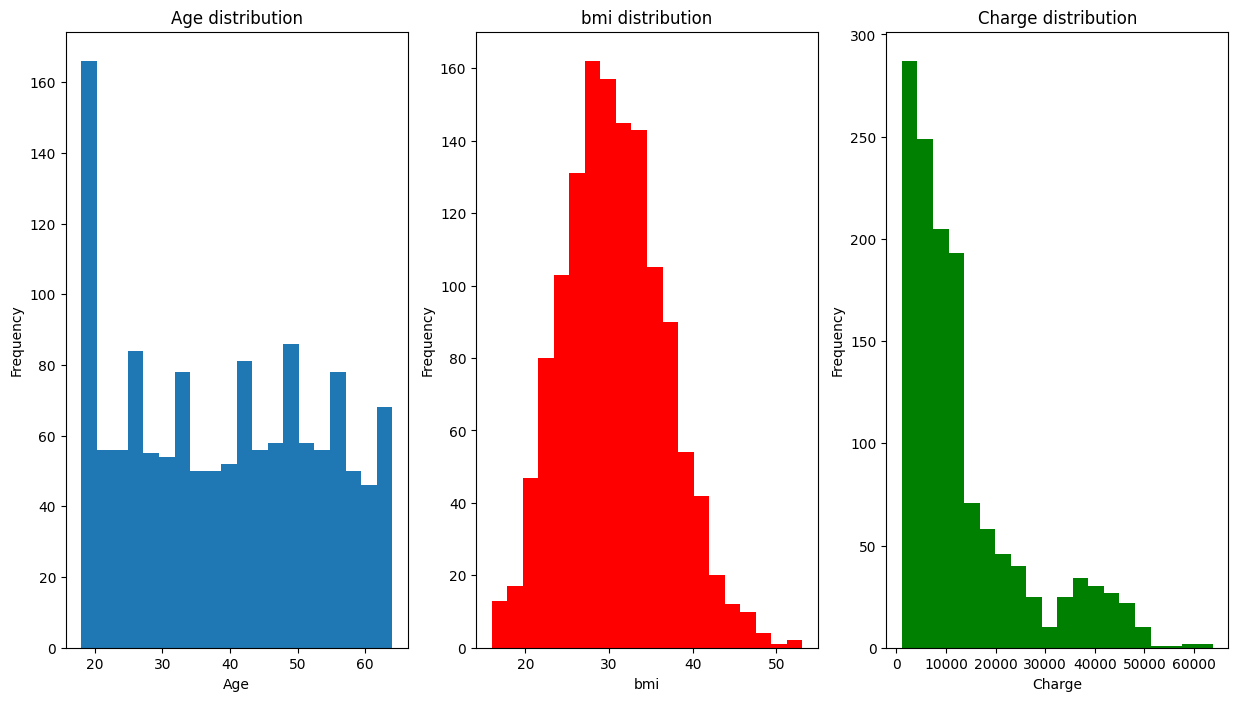

In [130]:
# Distribution of numeric values.

# Check for bmi , age and charges


fig = plt.figure()
fig.set_size_inches(15,8)

plt.subplot(131)
plt.hist(df["age"],bins=20)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age distribution") 

plt.subplot(132)

plt.hist(df["bmi"],bins=20,color="red")
plt.xlabel("bmi")
plt.ylabel("Frequency")
plt.title("bmi distribution")

plt.subplot(133)
plt.hist(df["charges"],bins=20,color="green")
plt.xlabel("Charge")
plt.ylabel("Frequency")
plt.title("Charge distribution")
plt.show()

<AxesSubplot: >

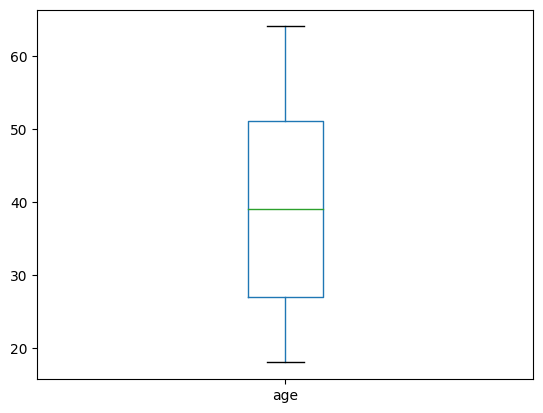

In [131]:
#Checking for outliers

df.boxplot("age",grid=False) # Age attribute has no extreme values.

<AxesSubplot: >

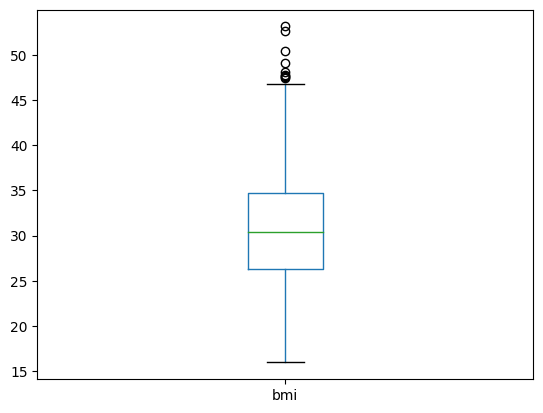

In [132]:
df.boxplot("bmi",grid=False) ## We can consider bmi > 50 values as outlier.

<AxesSubplot: >

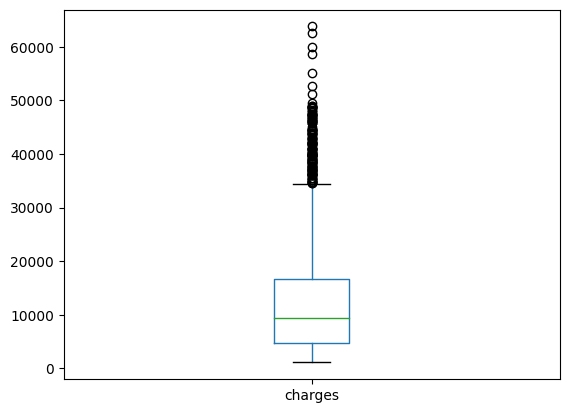

In [133]:
df.boxplot("charges",grid=False) # Charges > 40000 can be considered as outliers.

In [134]:
# Outlier deletion

outlier_bmi = df[df["bmi"] > 50].index
df.drop(outlier_bmi , axis = 0 , inplace= True)

outlier_charges=df[df["charges"] > 40000].index 
df.drop(outlier_charges, axis=0 , inplace= True)


In [135]:
# Scaling features
data = df.values # Transforming dataframe to numpy array

scaler = StandardScaler()
scaler.fit(data)




data = scaler.transform(data)
print(data)


[[-1.40182727 -0.99761621 -0.39654679 ... -0.57336955 -0.59174413
   1.74407587]
 [-1.47321347  1.00238949  0.59434882 ... -0.57336955  1.68991959
  -0.57336955]
 [-0.7593515   1.00238949  0.46436762 ... -0.57336955  1.68991959
  -0.57336955]
 ...
 [-1.47321347 -0.99761621  1.1142736  ... -0.57336955  1.68991959
  -0.57336955]
 [-1.25905488 -0.99761621 -0.75104096 ... -0.57336955 -0.59174413
   1.74407587]
 [ 1.59639299 -0.99761621 -0.1990429  ...  1.74407587 -0.59174413
  -0.57336955]]


K-Means Model

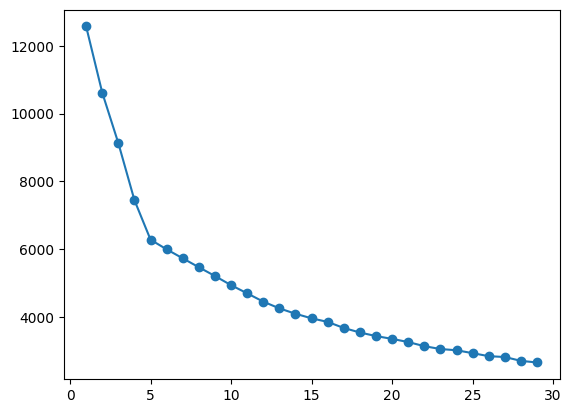

In [136]:
inertias = {}

# Calculating clusters for  k= 1 to k = 29
for i in range(1,30):
    model = KMeans(n_clusters= i)
    model.fit(data)
    inertias[i] = model.inertia_
    
 # Elbow   
plt.plot(inertias.keys(),inertias.values(),"-o")

plt.show()

# From graph we can choose 4 or 5 for best cluster number.

k_means_k = 5

modelk = KMeans(k_means_k)
modelk.fit(data)
cluster_labels = modelk.predict(data)



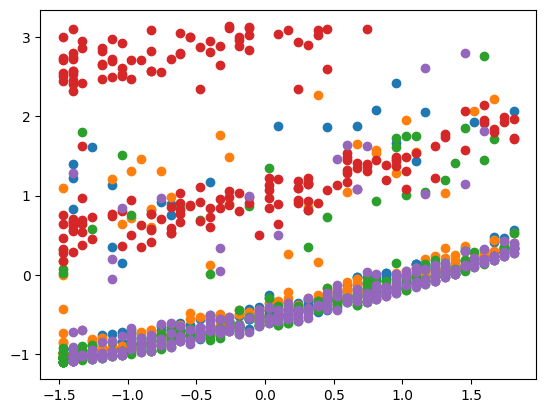

In [137]:
# Points on Age-Charges 


for cluster in range(k_means_k):
  cluster_mask = cluster_labels == cluster
  plt.scatter(data[cluster_mask, 0], data[cluster_mask, 5])
  

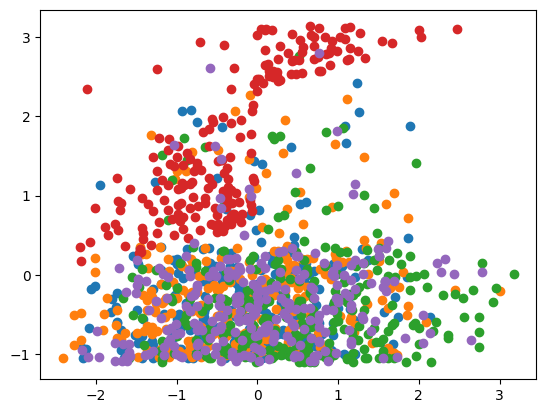

In [138]:
# Points on bmi-Charges
for cluster in range(k_means_k):
  cluster_mask = cluster_labels == cluster
  plt.scatter(data[cluster_mask, 2], data[cluster_mask, 5])
  

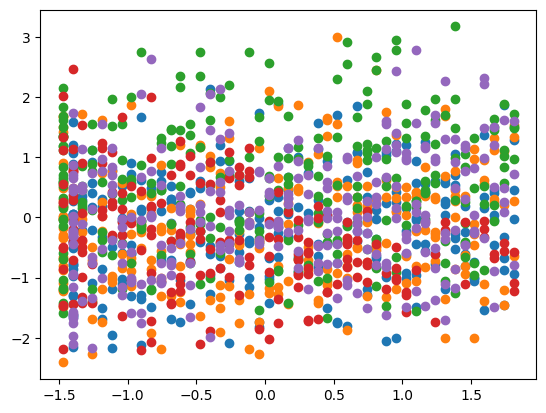

In [139]:
# Points on age-bmi
for cluster in range(k_means_k):
  cluster_mask = cluster_labels == cluster
  plt.scatter(data[cluster_mask, 0], data[cluster_mask, 2])
  

Agglomerative Clustering Model

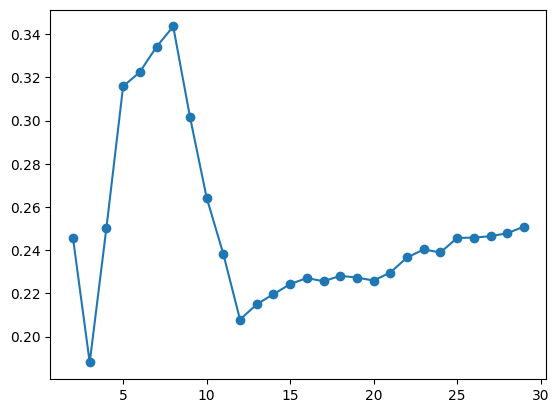

In [140]:
# I used silhoutte score for choosing the best cluster number.

silhoutte_Scores = {}

# Calculating clusters for  k= 1 to k = 29
for i in range(2,30):
    model = AgglomerativeClustering(n_clusters=i)
    labels = model.fit_predict(data)
    silhoutte_Scores[i] = silhouette_score(data,labels)
    
 # Elbow   
plt.plot(silhoutte_Scores.keys(),silhoutte_Scores.values(),"-o")

plt.show()

# From graph we can choose 8 for best cluster number because it has the highest silhoutte score 

agg_k = 8



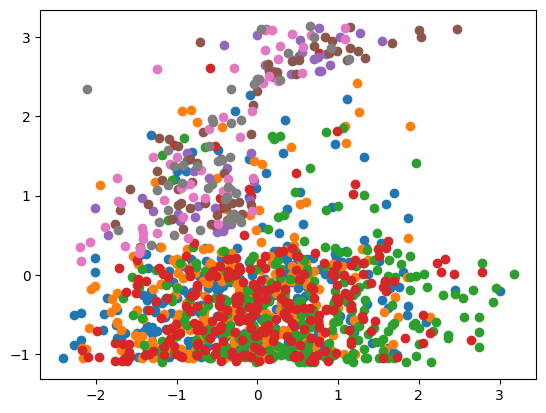

In [141]:
# Points on bmi - Charges

modelagg = AgglomerativeClustering(agg_k)
labels = modelagg.fit_predict(data)
for cluster in range(agg_k):
  cluster_mask = labels == cluster
  plt.scatter(data[cluster_mask, 2], data[cluster_mask, 5])



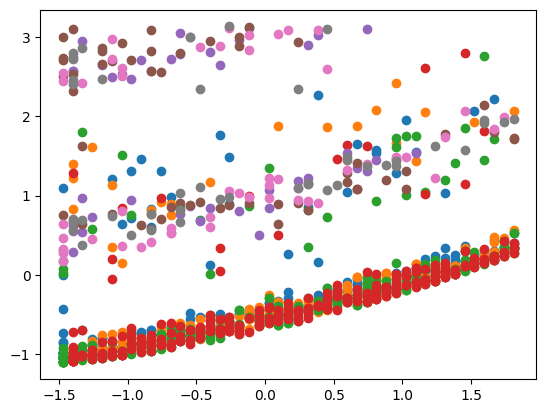

In [142]:
# Points on Age - charges
for cluster in range(agg_k):
  cluster_mask = labels == cluster
  plt.scatter(data[cluster_mask, 0], data[cluster_mask, 5])


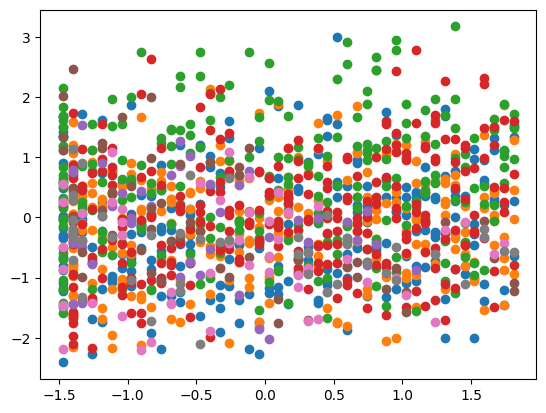

In [143]:
# Points on Age-bmi
for cluster in range(agg_k):
  cluster_mask = labels == cluster
  plt.scatter(data[cluster_mask, 0], data[cluster_mask, 2])

COMMENT FOR GRAPHS

    For both models, it looks like they fail to cluster properly for any attribute pair. It can be seen from silhoutte scores. They are very low. When I don't scale data, their scores get higher but they started to cluster data looking only to charges attribute (because of distance) , but we want to consider all attributes so we have to scale data.
    

SILHOUTTE SCORES


Mean silhoutte score for all points in K-Means:  0.3158
Mean silhoutte score for all points in Agglomerative Clustering:  0.3435


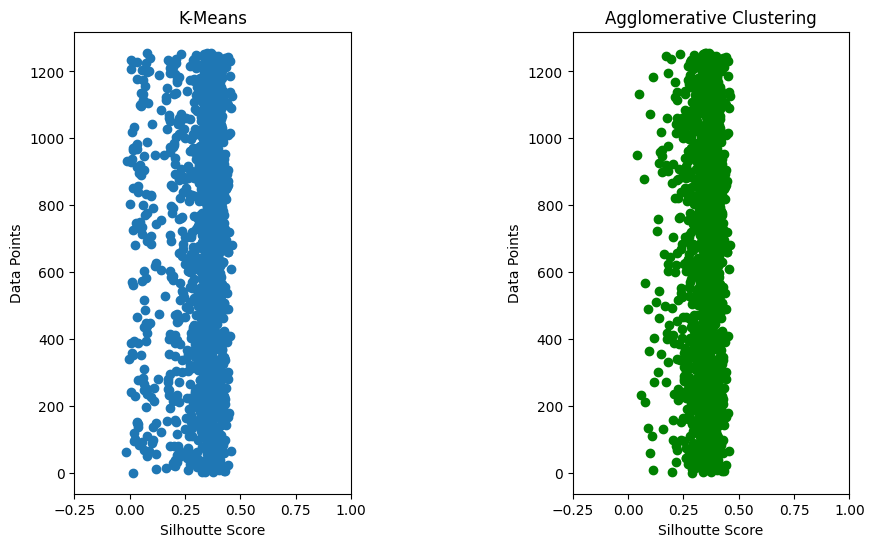

In [144]:

label_kmean = modelk.fit_predict(data)
label_agglomerative = modelagg.fit_predict(data)

silh_k = silhouette_samples(data,label_kmean)
silh_agg = silhouette_samples(data,label_agglomerative)

fig = plt.figure()
fig.subplots(1,2)

fig.subplots_adjust(wspace= 0.8)
fig.set_size_inches(10,6)
plt.subplot(121)
plt.scatter(silh_k,range(len(silh_k)))
plt.xlabel("Silhoutte Score")
plt.ylabel("Data Points")
plt.title("K-Means")
plt.xlim(-0.25,1)

plt.subplot(122)
plt.scatter(silh_agg,range(len(silh_agg)),color = "green")
plt.xlabel("Silhoutte Score")
plt.ylabel("Data Points")
plt.title("Agglomerative Clustering")
plt.xlim(-0.25,1)



print("Mean silhoutte score for all points in K-Means: " , silh_k.mean().round(4))
print("Mean silhoutte score for all points in Agglomerative Clustering: " , silh_agg.mean().round(4))

# Agglomerative clustering is slightly better than K-Means when we compare their silhoutte scores but in general, both of them have low scores.

